---
title: Flexible Deep Learning Training Loop
from: markdown+emoji
author: "Dien-Hoa Truong"
date: 2023-01-15
categories: [deeplearning]

---

Building a Flexible Training Loops via system of callbacks - fastai course part 2 2022 

![callback](https://iconarchive.com/download/i83699/custom-icon-design/mono-general-3/call-ringing.ico)


## Minimalist Training Loop 

```python
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count
```

If you are a data scientist, you might be familiar with the code above - a minimalist training loop. It does couple of things:

- Training through a number of epochs 
- In each epoch, loop through every batchs
- In each batch, depending on if the model is training or validating, having different behaviours

However, in most of the time, we won't stop here ... What if 🤔 :

- The dataset is unbalance, we should better adding more metrics than just accuracy, maybe `F1`, `ROCAUC`, ...
- You want to log the result: in a file / show in a realtime graph / push it on `WandB`
- `Early Stopping`, `Save Best Model`, and Much more ...

Then you will add more and more ideas in the training loop and. To the point that changing anything becomes a headache. You want to reactivate an old feature that you've tried last week, combine several ideas together, ... Big chance that you will just create new notebook with Learner-Copy1, Learner-Copy2, Learner-CopyN, ...

Let's today design a new Flexible Training Loop where we keep it as simple as possible but also having a full power of plugging new ideas via callbacks. 

::: {.callout-note}
Callback here is a not a python feature but a design concept. It's a just mean triggering a function when you've done something
:::

## Flexible Learner

There are 3 core pieces of a training loop

- Fit
- Epoch
- Batch

We will wrap around each event here a `before` and `after` method (so `before_batch` `after_batch` `before_epoch` `after_epoch` `before_fit` `after_fit`) with full access to the `Learner` (which includes everything: the model, optimizer, dataloader, ... ). 

```python
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
```

::: {.callout-note}
The `exception` here is for adding more control - exit an event when we need
:::

Pause for a second and imagine if you want to write a simple `DeviceCallBack`, what will you do ? ...

It's putting to the device (CUDA):

- Before_fit: Model -> CUDA
- Before_batch: (Input, Label) -> CUDA

```python
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)
```

```python
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
        wandb.log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))
```

How about calculating the metrics and logging to CSV / Push to WandB?

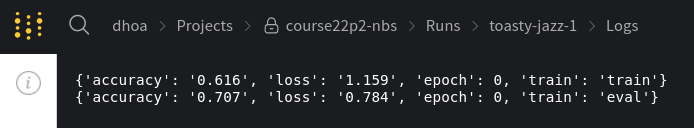

To define this Learner: ``` learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB()]) ```

## How to go even further?

We don't want to repeat ourselves so the `before` and `after` in the previous `Learner` version can be refactored. We can use @decorator or @contextmanager for wrapping something before and after the event.

The fastai course experiment this idea further with even considering ```'predict','get_loss','backward','step','zero_grad'``` as events. It means there are really nothing that we can not control here. An example of when it is useful is experimenting a Momentum Learner by rewritting the `zero_grad`

```python
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom
     
```

It means instead of forgetting all the previous gradient by asigning it to zero, we can multiply it by a number < 1. So in the next update, we also take into account what we've trained before ( or momentum ).